### Importing dependencies

In [1]:
## Import dependencies

import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt


In [2]:
## Import tensorflow dependencies - FUnctional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf



## Set GPU Growth

##### Avoid `Out of Memory` Error by setting GPU Memory Consumption Growth

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU') #list all the gpus present
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
len(gpus)

0

### Create folder structure

In [5]:
# Anchor means the original input image
# Positive means whether the original image and verification image matches
# Negetive means original image and verificationn image do not match

# Positive and negetive comes inside of verification image.

POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [6]:
# Make the directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

# Collect Positives and Anchors

### Unzip labelled Faces in Wild Dataset

In [7]:
# http://vis-www.cs.umass.edu/lfw/

In [8]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset

!tar -xf lfw.tgz

In [9]:
# Move LFW Images to the following repository data/negative

for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)
        

In [10]:
# for i in range(10):
# #     print("*")
#     for j in range(i+1):
#         print("*",end="")
#     print("")
        

In [11]:
os.listdir('lfw')

['Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abbas_Kiarostami',
 'Abba_Eban',
 'Abdel_Aziz_Al-Hakim',
 'Abdel_Madi_Shabneh',
 'Abdel_Nasser_Assidi',
 'Abdoulaye_Wade',
 'Abdulaziz_Kamilov',
 'Abdullah',
 'Abdullah_Ahmad_Badawi',
 'Abdullah_al-Attiyah',
 'Abdullah_Gul',
 'Abdullah_Nasseef',
 'Abdullatif_Sener',
 'Abdul_Majeed_Shobokshi',
 'Abdul_Rahman',
 'Abel_Aguilar',
 'Abel_Pacheco',
 'Abid_Hamid_Mahmud_Al-Tikriti',
 'Abner_Martinez',
 'Abraham_Foxman',
 'Aby_Har-Even',
 'Adam_Ant',
 'Adam_Freier',
 'Adam_Herbert',
 'Adam_Kennedy',
 'Adam_Mair',
 'Adam_Rich',
 'Adam_Sandler',
 'Adam_Scott',
 'Adelina_Avila',
 'Adel_Al-Jubeir',
 'Adisai_Bodharamik',
 'Adolfo_Aguilar_Zinser',
 'Adolfo_Rodriguez_Saa',
 'Adoor_Gopalakarishnan',
 'Adriana_Lima',
 'Adriana_Perez_Navarro',
 'Adrianna_Zuzic',
 'Adrian_Annus',
 'Adrian_Fernandez',
 'Adrian_McPherson',
 'Adrian_Murrell',
 'Adrian_Nastase',
 'Adrien_Brody',
 'Afton_S

### Collect Positive and Anchor Classes

In [12]:
## uuid library to generate unique image names
import uuid #universal uniform identifier
import os

In [9]:
'{}.jpg'.format(uuid.uuid1())

'6494cf82-47a3-11ec-9fd3-4074e0844ddc.jpg'

In [10]:
os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\64b69a8a-47a3-11ec-90f1-4074e0844ddc.jpg'

In [22]:
## Establish a connection to the webcam

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read() #capture video frame by frame
    
    #Cut down frame to 250px x 250px
    frame = (frame[220:220+250,250:250+250:])
    
    # Collect anchors 
    if cv2.waitKey(1) & 0xFF == ord('a'): # on pressing 'a' it collects anchor images
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname,frame)
    
    # Collect Positives
    if cv2.waitKey(1) & 0xFF == ord('p'): # on pressing 'p' it collects positive images
        # Create the unique file path
        imgname = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname,frame)
    
    
    
    
    cv2.imshow('frame',frame) # render image backk to screen
    
    if cv2.waitKey(1) & 0xFF == ord('q'): # the 'q' button is set as the quitting button
        break

cap.release()
cv2.destroyAllWindows() 
    
    

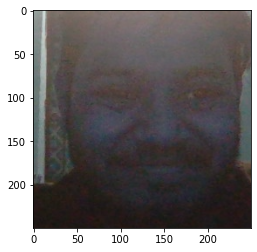

In [23]:
plt.imshow(frame)

In [24]:
frame.shape

(250, 250, 3)

In [25]:
# plt.imshow(frame[120:120+250,200:200+250:])

# Data Augmentation

In [26]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [29]:
import os
import uuid

In [39]:
img_path = os.path.join(ANC_PATH, '00a399b8-4052-11ec-b850-4074e0844ddc.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())



In [33]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# Load and Preprocess Image

### Get image Directories

In [40]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000) # go and grab all of the different image wthin a specific directory. Only take 300 images 
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [41]:
dir_test = anchor.as_numpy_iterator()

In [42]:
dir_test.next() # Continue grabbing the next element

b'data\\anchor\\2adce176-3e1c-11ec-9a63-4074e0844ddc.jpg'

### Preprocessing scale and Resize

In [43]:
def preprocess(file_path):
    
    # Read image from file path 
    byte_img = tf.io.read_file(file_path)
    # Load the image
    img = tf.image.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img,(100,100))
    
    # Scale image to be between 0 and 1
    img = img/255.0
    
    # Return the image
    return img
    

In [44]:
img = preprocess('data\\anchor\\a394e16c-3e1a-11ec-8494-4074e0844ddc.jpg')

In [45]:
img.numpy().max()

0.73357844

In [46]:
img.numpy().min()

0.025245098

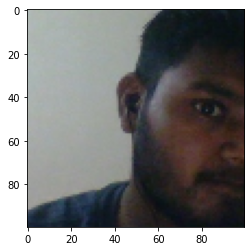

In [47]:
plt.imshow(img)

In [48]:
# dataset.map(preprocess)

### Create Labelled Dataset

In [49]:

# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [50]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

In [51]:
# positives will be containing data having 1 and negatives data having 0
positives =  tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [52]:
samples = data.as_numpy_iterator()

In [53]:
exampple = samples.next() #it contains anchor data positive value and labels

In [54]:
exampple

(b'data\\anchor\\82bb16c6-3e1a-11ec-811d-4074e0844ddc.jpg',
 b'data\\positive\\461b00dc-493b-11ec-a976-4074e0844ddc.jpg',
 1.0)

### Build Train and Test Partition

In [55]:
def preprocess_twin(input_img, validation_img,label):
    """
    input_img is anchor
    validation_img is either positive or negative
    respective label is also returned
        
    """
    return(preprocess(input_img),preprocess(validation_img),label) 


In [56]:
res = preprocess_twin(*exampple)

In [57]:
len(res)

3

In [58]:
res[0]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.6997549 , 0.74289215, 0.7272059 ],
        [0.6938726 , 0.7360294 , 0.7232843 ],
        [0.6909314 , 0.73014706, 0.7262255 ],
        ...,
        [0.04509804, 0.08039216, 0.10147059],
        [0.0497549 , 0.08872549, 0.09730392],
        [0.05857843, 0.08995098, 0.09779412]],

       [[0.6960784 , 0.7343137 , 0.73039216],
        [0.67720586, 0.71642154, 0.7129902 ],
        [0.6901961 , 0.7294118 , 0.72745097],
        ...,
        [0.0495098 , 0.08529412, 0.09387255],
        [0.04313726, 0.0754902 , 0.08039216],
        [0.05931373, 0.09460784, 0.09068628]],

       [[0.6897059 , 0.725     , 0.72107846],
        [0.6877451 , 0.7247549 , 0.72132355],
        [0.6865196 , 0.7257353 , 0.7237745 ],
        ...,
        [0.0504902 , 0.08799019, 0.09215686],
        [0.04411765, 0.08235294, 0.08431373],
        [0.04632353, 0.08455882, 0.08651961]],

       ...,

       [[0.12745099, 0.19117647, 0.25220588],
        [0.10

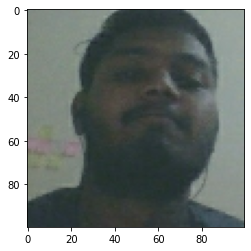

In [59]:
plt.imshow(res[1]) # EIther positive or negative

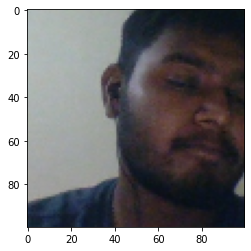

In [60]:
plt.imshow(res[0])# annchoe

In [61]:
res[2] #label

1.0

In [62]:
# Build data loader pipeline

data = data.map(preprocess_twin)
data = data.cache() #caching our images
data = data.shuffle(buffer_size=10000) # shuffle the data

In [63]:
data

<ShuffleDataset shapes: ((100, 100, None), (100, 100, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [64]:

##### <ShuffleDataset shapes: ((100, 100, None) #anchor image, (100, 100, None) #negative or positive image, ()) #label, types: (tf.float32, tf.float32, tf.float32)>

In [65]:
samples = data.as_numpy_iterator()

In [66]:
samp = samples.next()

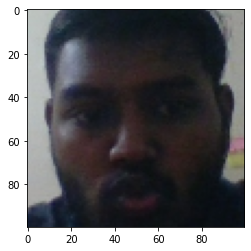

In [67]:
plt.imshow(samples.next()[0])

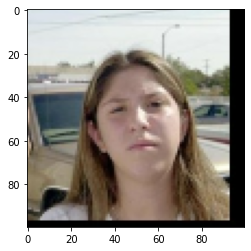

In [68]:
plt.imshow(samples.next()[1])

#### keeping the image constant using samp variable

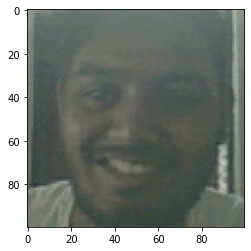

In [69]:
plt.imshow(samp[0])

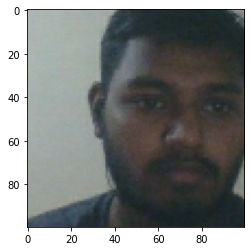

In [70]:
plt.imshow(samp[1])

In [71]:
samp[2]

1.0

In [72]:
### Training and testing partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8) # starts preparing the data before head


In [73]:
round(len(data)*.7)

643

In [74]:
train_data

<PrefetchDataset shapes: ((None, 100, 100, None), (None, 100, 100, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>

In [75]:
# testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [76]:
test_data

<PrefetchDataset shapes: ((None, 100, 100, None), (None, 100, 100, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>

In [77]:
(round(len(data)*.3))

275

# Model Engineering

### Build Embedding layer

In [78]:
inp = Input(shape=(100,100,3),name='input_image')
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [79]:
c1 = Conv2D(64,(10,10),activation='relu')(inp)
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [80]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [81]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [82]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [83]:

c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [84]:

mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [85]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [86]:
def make_embedding():
    inp = Input(shape=(100,100,3),name='input_image')
    #first block
    c1 = Conv2D(64,(10,10),activation='relu')(inp) #inp is connecting with first layer
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    #second block 
    c2 = Conv2D(128,(7,7),activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    
    #Third block
    c3 = Conv2D(128,(4,4),activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2),padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256,(4,4),activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096,activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp] , outputs=[d1] , name='embedding')


In [87]:
embedding = make_embedding()

In [88]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

### Build distance layer

In [89]:
# siamese L1 distance class
class L1Dist(Layer): #layer comes from import layers
    """Takes output of the embedding.
    Subtracts the Anchor from either positive or negative
    so that we can compare both the faces"""
    
    def __init__(self,**kwargs):
        super().__init__()
        
    #similarity calculation
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)


In [90]:
l1 = L1Dist()

### Make siamese model

In [91]:
input_image = Input(name='input_img',shape=(100,100,3))
validation_image = Input(name='validation_img',shape=(100,100,3))

In [92]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [93]:
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [94]:
val_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [95]:
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding) # distance b/w i/p embedding and validation embedding

In [96]:
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [97]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [98]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

##### Create a funtion for above stuff

In [99]:
def make_siamese_model():
    
    # Anchor image i/p in the n/w
    input_image = Input(name='input_img',shape=(100,100,3)) #this Input module is from tensorflow.keras.layers
    #validation image i/p in the n/w
    validation_image = Input(name='validation_img',shape=(100,100,3))
    
    # combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image)) # distance b/w i/p embedding and validation embedding
    
    # classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs = [input_image,validation_image], outputs=classifier,name = 'SiameseNetwork')



In [100]:

siamese_model = make_siamese_model()

In [101]:
siamese_model.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

# Training

### Setup loss and Optimizers

In [102]:
binary_cross_loss = tf.losses.BinaryCrossentropy()


In [103]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

### Establish checkpoints

In [104]:

if not os.path.exists('training_checkpoints'):
    os.makedirs('training_checkpoints')
    
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model=siamese_model)


## To load pretrained weights form last checkpoint use
# model.load('path_to_checkpoint')

### Build train step function

In [105]:
test_batch = train_data.as_numpy_iterator()

In [106]:
batch_1 = test_batch.next()

In [107]:
len(batch_1)

3

In [108]:
len(batch_1[0])

16

In [109]:
len(batch_1[1])

16

In [110]:
batch_1[2] #label

array([0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.],
      dtype=float32)

In [111]:
X = batch_1[:2]

In [112]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [113]:
y = batch_1[2]

In [114]:
y

array([0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.],
      dtype=float32)

In [115]:
@tf.function # compiles a function into a callable tensorflow graph

def train_step(batch):
    with tf.GradientTape() as tape:
        #Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # calculate loss
        loss = binary_cross_loss(y,yhat)
        print(loss)
    
        # calculate gradients
        grad = tape.gradient(loss, siamese_model.trainable_variables)
        
        # Calculate updated weights and apply to siamese model
        opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
        # the optimizer here is calculating and propagating the new weights using
        # adam's optimiation algorithm.
        
        return loss
    

### Build training loop

In [120]:
### Import metric calculations
from tensorflow.keras.metrics import Precision,Recall

In [121]:
def train(data, Epochs):
    """Takes data and Epochs as inputs 
    and trains the model"""
    for epoch in range(1,EPOCHS+1):
        print('\n epoch {}/{}'.format(epoch,Epochs))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx,batch in enumerate(train_data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2],yhat)
            p.update_state(batch[2],yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
            
        # Save checkpoints
        if epoch % 10 ==0:
            checkpoint.save(file_prefix = checkpoint_prefix)

In [122]:
EPOCHS = 50

In [123]:
train(train_data,EPOCHS)


 epoch 1/50
41/41 [==============================] - 1037s 25s/step
0.11075241 0.75617284 0.9919028

 epoch 2/50
41/41 [==============================] - 991s 24s/step
0.003891932 0.93949044 1.0

 epoch 3/50
41/41 [==============================] - 990s 24s/step
0.06543856 0.9874214 1.0

 epoch 4/50
41/41 [==============================] - 1008s 25s/step
0.010394324 0.9969419 1.0

 epoch 5/50
41/41 [==============================] - 1075s 26s/step
0.2236153 0.9969325 1.0

 epoch 6/50
41/41 [==============================] - 1013s 25s/step
8.021275e-05 1.0 1.0

 epoch 7/50
41/41 [==============================] - 1086s 26s/step
9.865899e-05 1.0 1.0

 epoch 8/50
41/41 [==============================] - 1031s 25s/step
0.00061038096 1.0 1.0

 epoch 9/50
41/41 [==============================] - 1100s 27s/step
0.007183244 1.0 1.0

 epoch 10/50
41/41 [==============================] - 1107s 27s/step
3.6956506e-05 1.0 1.0

 epoch 11/50


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\manda\anaconda3\envs\cv\lib\site-packages\IPython\core\interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-123-c22ce52f7b33>", line 1, in <module>
    train(train_data,EPOCHS)
  File "<ipython-input-121-5d452e9017f7>", line 15, in train
    loss = train_step(batch)
  File "C:\Users\manda\anaconda3\envs\cv\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\manda\anaconda3\envs\cv\lib\site-packages\tensorflow\python\eager\def_function.py", line 855, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "C:\Users\manda\anaconda3\envs\cv\lib\site-packages\tensorflow\python\eager\function.py", line 2943, in __call__
    filtered_flat_args, captured_inputs=graph_function.captured_inputs)  # pylint: disable=protected-access
  File "C:\Users\manda\an

KeyboardInterrupt: 

# EValuate Model

In [124]:
test_input,test_val,y_true = test_data.as_numpy_iterator().next()

In [125]:
test_var = test_data.as_numpy_iterator().next()

In [126]:
len(test_var[0]) #anchor

16

In [127]:
len(test_var[1]) # positive/negative

16

In [128]:
test_var[2]

array([0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.],
      dtype=float32)

In [129]:
y_true

array([1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.],
      dtype=float32)

In [130]:
# Make predictions
y_hat = siamese_model.predict([test_input,test_val])
y_hat

array([[9.9999940e-01],
       [9.9996072e-01],
       [8.1440806e-04],
       [1.0552503e-05],
       [9.9966609e-01],
       [9.9995458e-01],
       [9.9996591e-01],
       [1.3326406e-03],
       [1.0000000e+00],
       [9.9999976e-01],
       [1.0014801e-04],
       [9.9999976e-01],
       [9.9945563e-01],
       [9.9999601e-01],
       [9.8951697e-01],
       [9.9989283e-01]], dtype=float32)

### Make Predictions

In [131]:
# Post processing the result
[1 if prediction > 0.5 else 0 for prediction in y_hat]


[1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]

In [132]:
y_true

array([1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.],
      dtype=float32)

In [133]:
# creating a metric object
m = Recall()
#calculating recall value
m.update_state(y_true,y_hat)
# Return rcall Result
m.result().numpy()

1.0

In [136]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.5833333

In [137]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1.0 1.0


### Visualize the result

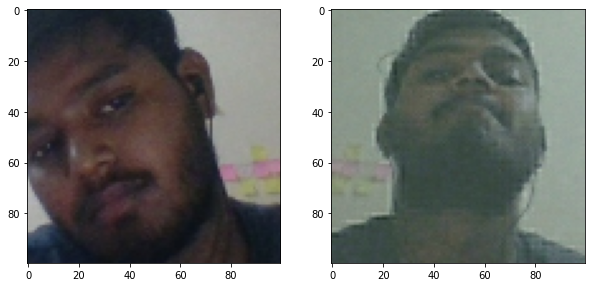

In [143]:

# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# Save Model

In [139]:
## Save weights
siamese_model.save('siamesemodel_v2.h5')

In [140]:
# Reload the model
model = tf.keras.models.load_model('siamesemodel_v2.h5',custom_objects={'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [141]:
model.predict([test_input,test_val])

array([[0.99999744],
       [0.998322  ],
       [0.99996746]], dtype=float32)

In [142]:
# View model summary

siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

# Real Time Test

In [144]:
## Create few directories and folders

if not os.path.exists('application_data'):
    os.makedirs('application_data')
    
subfolder_names = ['input_image','verification_images']

if not subfolder_name 
for subfolder_name in subfolder_names:
    os.makedirs(os.path.join('application_data',subfolder_name))

os.makedirs('application_data',exist_ok=True)

SyntaxError: invalid syntax (<ipython-input-144-c440d199d049>, line 8)

In [145]:
# copy random files from one positive folder to verification_image folder

import os
import random
import shutil

source = 'data/positive'
dest = 'application_data/verification_images'

files = os.listdir(source)
no_of_files = 50

path, dirs, files_len = next(os.walk('application_data/verification_images')) #dir is your directory path as string

print("Total number of files in directory are :",len(files_len))

if len(files_len) < 50:
    for file_name in random.sample(files,no_of_files):
        shutil.copy(os.path.join(source,file_name),dest)
else:
    pass


Total number of files in directory are : 50


### Verification Function

In [146]:
os.listdir(os.path.join('application_data','verification_images'))

['00fa4750-3e1c-11ec-8c80-4074e0844ddc.jpg',
 '01476648-3e1c-11ec-b1d2-4074e0844ddc.jpg',
 '016f8302-3e1c-11ec-bc50-4074e0844ddc.jpg',
 '022b7446-3e1c-11ec-ac09-4074e0844ddc.jpg',
 '02795f08-3e1c-11ec-9c9a-4074e0844ddc.jpg',
 '02a81e36-3e1c-11ec-bdda-4074e0844ddc.jpg',
 '02c662e2-3e1c-11ec-9f1a-4074e0844ddc.jpg',
 '045aa926-3e1c-11ec-9158-4074e0844ddc.jpg',
 '04a8894a-3e1c-11ec-9b7d-4074e0844ddc.jpg',
 '05c8ed1e-3e1c-11ec-b2da-4074e0844ddc.jpg',
 '06ce2376-3e1c-11ec-a946-4074e0844ddc.jpg',
 '07433070-3e1c-11ec-bfbe-4074e0844ddc.jpg',
 '07a4e8ca-3e1c-11ec-ae55-4074e0844ddc.jpg',
 '07f59c0c-3e1c-11ec-b7a0-4074e0844ddc.jpg',
 '08808cc8-3e1c-11ec-8a38-4074e0844ddc.jpg',
 '08be7ae8-3e1c-11ec-aaa3-4074e0844ddc.jpg',
 '08f5dd86-3e1c-11ec-b20d-4074e0844ddc.jpg',
 '09612aec-3e1c-11ec-9fef-4074e0844ddc.jpg',
 '0a52f1ee-3e1c-11ec-956b-4074e0844ddc.jpg',
 '0b1af19a-3e1c-11ec-b771-4074e0844ddc.jpg',
 '0b7dec82-3e1c-11ec-97c9-4074e0844ddc.jpg',
 '0bad7e40-3e1c-11ec-895e-4074e0844ddc.jpg',
 '0bb755fe

In [147]:
os.path.join('application_data','input_image','input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [149]:
for image in os.listdir(os.path.join('application_data','verification_images')):
    validation_img = preprocess(os.path.join('application_data','verification_images',image))
    print(validation_img)

tf.Tensor(
[[[0.6752451  0.7105392  0.6987745 ]
  [0.6754902  0.71862745 0.7029412 ]
  [0.6754902  0.71568626 0.7088235 ]
  ...
  [0.5595588  0.5615196  0.54289216]
  [0.5745098  0.57058823 0.55196077]
  [0.55490196 0.5509804  0.5352941 ]]

 [[0.6816176  0.71789217 0.71593136]
  [0.67058825 0.70980394 0.7078431 ]
  [0.6669118  0.70612746 0.70416665]
  ...
  [0.5492647  0.5541667  0.53455883]
  [0.5529412  0.55857843 0.53455883]
  [0.5588235  0.5568628  0.5362745 ]]

 [[0.6754902  0.7147059  0.72156864]
  [0.6752451  0.7144608  0.72132355]
  [0.67156863 0.7107843  0.7176471 ]
  ...
  [0.54607844 0.5605392  0.54607844]
  [0.5539216  0.5617647  0.5421569 ]
  [0.54093134 0.5507353  0.5242647 ]]

 ...

 [[0.40392157 0.40514705 0.45      ]
  [0.32818627 0.35245097 0.39191177]
  [0.27254903 0.30318627 0.35784313]
  ...
  [0.05735294 0.07965686 0.12156863]
  [0.05514706 0.07083333 0.11789215]
  [0.06176471 0.07156863 0.11715686]]

 [[0.23872548 0.28186274 0.35637254]
  [0.1877451  0.26960784 0

In [150]:
def verify(model, detection_threshold, verification_threshold):
    """
    
    model is what model are we going to use for predictions
    Detection threshold is a metric above which a prediction is considered
    positive.
    Verification threshold is a proportion of a positive predictions / total positive
    samples
    
    Has input_img function that preprocess the image and saves it in application_data/input_image/input_image.jpg
    file path.
    """
    
    # Build results list
    results = []
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img = preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        #preprocess function that we created above to scale,resize and noramlize the images
        validation_img = preprocess(os.path.join('application_data','verification_images',image))
        
        result = model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        results.append(result)
    
    
    detection = np.sum(np.array(results) > detection_threshold) # it determines how many of our
    # positive prediction are actually surpassing the detection_threshold
    
    verification = detection/len(os.listdir(os.path.join('application_data', 'verification_images')))
    
    verified = verification > verification_threshold
    
    return results, verified


### OpenCV Real time verification

In [151]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    frame = (frame[220:220+250,250:250+250:])
    
    cv2.imshow('verification',frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'),frame)
        
        
        # Run verification
        results,verified = verify(model,0.7,0.9)
        print(verified)
        
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()
    

True


In [152]:
np.squeeze(results) > 0.5

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [153]:
np.sum(np.squeeze(results)>0.5)

50

In [ ]:
### Create a folder in app directory if it doesn't already exists
if not os.path.exists('app/application_data'):
    shutil.copytree('application_data', 'app/application_data')

In [ ]:
! git add Facial_verification_siamese.ipynb
! git commit -m "22:06/19-11-2021"
! git push -u origin main